Modele selected: VGG19

In [ ]:
import os, time
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

In [3]:
root = os.path.dirname(os.path.dirname(os.getcwd()))

train_dir = os.path.join(root, 'data', 'current', 'train')

IMAGE_DIM = 150
NB_CLASS = 3
NB_EPOCH = 7
L_RATE = 0.001
BATCH = 64

In [4]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,             # Zoom
    rotation_range=20,          # Rotation des images
    width_shift_range=0.001,      # Translation horizontale
    height_shift_range=0.001,     # Translation verticale
    shear_range=0.01,            # Transformation affine
    horizontal_flip=True,       # Symétrie horizontale
    fill_mode='nearest',        # Remplir les zones vides après transformation
    validation_split=0.2        # Division en validation
)

train_data = datagen_train.flow_from_directory(
    train_dir,
    seed = 42,
    color_mode = 'rgb',
    target_size=(IMAGE_DIM, IMAGE_DIM), 
    batch_size=BATCH,
    class_mode='categorical',      
    subset='training'
)

val_data = datagen_train.flow_from_directory(
    train_dir,
    seed = 42,
    color_mode = 'rgb',
    target_size=(IMAGE_DIM, IMAGE_DIM),
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation'
)


Found 1080 images belonging to 3 classes.
Found 269 images belonging to 3 classes.


In [5]:

def model_builder (model, name = str(time.time()), epoch = NB_EPOCH, lr = L_RATE):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    # -- compile --
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print(model.summary())
    class_weights = dict(enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_data.classes),
        y=train_data.classes
    )))
    # -- train --
    # Use checkpoints
    checkpoint_path =  os.path.join(root, 'model', 'checkpoints', 'cp.weights.h5')
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=3, verbose=1
    )
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epoch,
        callbacks=[cp_callback, lr_callback, early_stopping],
        # steps_per_epoch=train_steps,
        # validation_steps=val_steps,
        class_weight=class_weights
    )
    # -- save --
    save_path =  os.path.join(root, 'model', 'VGG19', 'model_' + name + '.h5')
    model.save(save_path)
    # -- Evaluate --
    test_loss, test_acc = model.evaluate(val_data)
    print(f"Test Accuracy: {test_acc*100:.2f}%")

    # Prédictions sur le set de test
    predictions = model.predict(val_data)
    predicted_classes = predictions.argmax(axis=1)
    print("Predictions done.")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

None
Epoch 1/7


c:\Users\tgoor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4843 - loss: 1.2585
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.4898 - loss: 1.2428 - val_accuracy: 0.8513 - val_loss: 0.4725 - learning_rate: 0.0010
Epoch 2/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7969 - loss: 0.5286
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - accuracy: 0.7980 - loss: 0.5247 - val_accuracy: 0.9033 - val_loss: 0.3093 - learning_rate: 0.0010
Epoch 3/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8806 - loss: 0.3046
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - accuracy: 0.8805 - loss: 0.3047 - val_accuracy: 0.9442 - val_loss: 0.2045 - learning_rate: 0.0010
Epoch 4/7
17/17 ━━━━━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9667 - loss: 0.1233
Test Accuracy: 95.54%
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step
Predictions done.


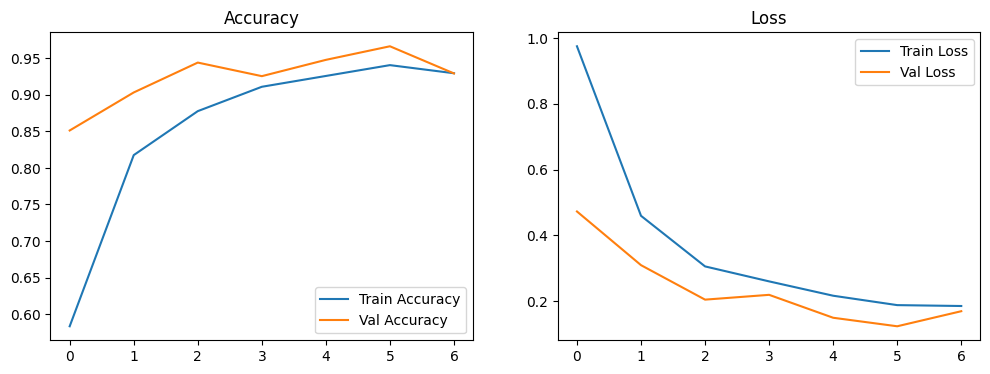

In [6]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# VGG16
model_builder(model,'VGG19_128')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

None
Epoch 1/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5348 - loss: 1.9914
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - accuracy: 0.5398 - loss: 1.9604 - val_accuracy: 0.8513 - val_loss: 0.4018 - learning_rate: 0.0010
Epoch 2/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8011 - loss: 0.4853
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - accuracy: 0.8030 - loss: 0.4826 - val_accuracy: 0.9219 - val_loss: 0.2512 - learning_rate: 0.0010
Epoch 3/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9246 - loss: 0.2880
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.9239 - loss: 0.2883 - val_accuracy: 0.9331 - val_loss: 0.1947 - learning_rate: 0.0010
Epoch 4/

5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.9319 - loss: 0.1363
Test Accuracy: 93.31%
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step
Predictions done.


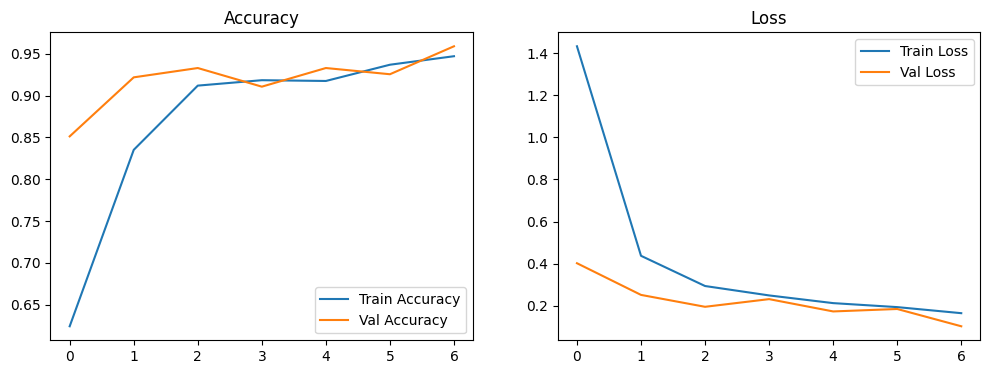

In [7]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# VGG16
model_builder(model,'VGG19_256')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

None
Epoch 1/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5642 - loss: 0.8842
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step - accuracy: 0.5715 - loss: 0.8720 - val_accuracy: 0.8773 - val_loss: 0.3836 - learning_rate: 0.0010
Epoch 2/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8246 - loss: 0.5343
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.8267 - loss: 0.5278 - val_accuracy: 0.9145 - val_loss: 0.2513 - learning_rate: 0.0010
Epoch 3/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9173 - loss: 0.2483
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.9176 - loss: 0.2475 - val_accuracy: 0.9145 - val_loss: 0.2637 - learning_rate: 0.0010
Epoch 4/

5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9653 - loss: 0.1082
Test Accuracy: 95.91%


4/5 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002D6465E4E00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step
Predictions done.


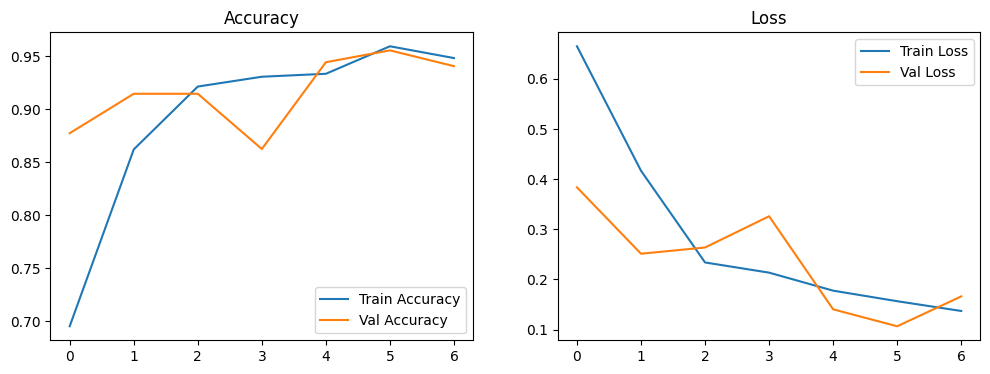

In [8]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# VGG16
model_builder(model,'VGG19_128_x2')

Conclusion: Breadth better than depth